env: KERAS_BACKEND=tensorflow


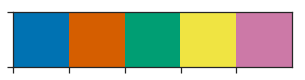

In [6]:
import sys
import os
from glob import glob
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import pysam
import h5py
from joblib import Parallel, delayed

%env KERAS_BACKEND tensorflow
import tensorflow as tf
from keras import (
    models, layers, activations,
    optimizers, losses, callbacks
)
import keras.backend as K
import keras

from sklearn.metrics import (
    roc_curve, precision_recall_curve, roc_auc_score
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle

from adapter_detector.utils import (
    get_fast5_read_id_mapping
)
from adapter_detector.signal import (
    get_fast5_fiveprime
)
from adapter_detector.train import (
    generate_training_data,
    build_model, train_model,
    SquiggleSequence
)

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [8]:
keras.__version__

'2.2.4'

In [9]:
tf.__version__

'1.10.0'

First we need to create the mapping between read ids and Fast5 files so that we can pair full length reads from the bam files with the signal that they originated from. This information is present in the sequencing summaries file:

In [3]:
read_id_filemap = get_fast5_read_id_mapping(
    '/cluster/ggs_lab/mtparker/analysis_notebooks/fiveprime_adapter_identification/data/201804_col0_5adapterLIG/5prime_adapter_rebasecalled/',
    '/cluster/ggs_lab/mtparker/analysis_notebooks/fiveprime_adapter_identification/data/201804_col0_5adapterLIG/5prime_adapter_fast5s/'
)

In [2]:
positive_bam_fn = '/cluster/gjb_lab/nschurch/git/NS_Nanopore_paper/manuscript/supplementary/fulllength_data/201902_col0_2916_5adapter_exp2_fulllength.bam'
negative_bam_fn = '/cluster/gjb_lab/nschurch/git/NS_Nanopore_paper/manuscript/supplementary/fulllength_data/201902_col0_2916_5adapter_exp2_short_relaxed.bam'


In [3]:
with pysam.AlignmentFile(positive_bam_fn) as p:
    print(p.mapped)

72083


In [4]:
with pysam.AlignmentFile(negative_bam_fn) as n:
    print(n.mapped)

151289


In [5]:
keras

NameError: name 'keras' is not defined

Now we can extract the 5' end signals (last 3000 signal measurements) from each Fast5 file. We also extract a bunch of internal signals to use as negative examples as well

In [6]:
def get_fiveprime_for_reads_in_bam(bam_fn, read_id_filemap, size=3000, internal=False):
    with pysam.AlignmentFile(bam_fn) as bam:
        signals = Parallel(n_jobs=16)(
            delayed(get_fast5_fiveprime)(
                r.query_name, read_id_filemap[r.query_name], size, internal)
            for r in bam.fetch()
        )
    if internal:
        read_ids, sig_lens, fiveprime_signals, internal_signals = zip(*signals)
        internal_signals = [x for x in internal_signals if x is not None and len(x) == size]
        return np.asarray(fiveprime_signals), np.asarray(internal_signals)
    else:
        read_ids, sig_lens, fiveprime_signals = zip(*signals)
        return np.asarray(fiveprime_signals)

pos_signals = get_fiveprime_for_reads_in_bam(
    positive_bam_fn, read_id_filemap, size=3000, internal=False)
neg_signals, neg_signals_internal = get_fiveprime_for_reads_in_bam(
    negative_bam_fn, read_id_filemap, size=3000, internal=True)

/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/cluster/ggs_lab/mtparker/.conda/envs/ad

In [9]:
def write_to_hdf5(h5_fn, pos_signals, neg_signals, neg_signals_internal):
    with h5py.File(h5_fn, 'w') as f:
        f.create_dataset('pos_signals', data=pos_signals)
        f.create_dataset('neg_signals', data=neg_signals)
        f.create_dataset('neg_internal_signals', data=neg_signals_internal)

In [8]:
write_to_hdf5(
    'data/training_data_round1.h5',
    pos_signals, neg_signals, neg_signals_internal
)

In [2]:
EPOCHS = 100
BATCH_SIZE = 128
STEPS_PER_EPOCH = 100
VAL_STEPS_PER_EPOCH = 20

train_gen, val_gen, test_data, _ = generate_training_data(
    'data/training_data_round1.h5',
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    val_steps_per_epoch=VAL_STEPS_PER_EPOCH
)

Reading in HDF data
Splitting training and test datasets
Building Sequence generators


In [3]:
model, history = train_model(
    model, train_gen, val_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    val_steps_per_epoch=VAL_STEPS_PER_EPOCH
)

Epoch 1/100
 - 28s - loss: 0.6617 - val_loss: 0.5381
Epoch 2/100
 - 23s - loss: 0.4670 - val_loss: 0.3693
Epoch 3/100
 - 24s - loss: 0.3580 - val_loss: 0.3059
Epoch 4/100
 - 24s - loss: 0.3151 - val_loss: 0.3837
Epoch 5/100
 - 24s - loss: 0.2955 - val_loss: 0.2756
Epoch 6/100
 - 25s - loss: 0.2622 - val_loss: 0.2450
Epoch 7/100
 - 24s - loss: 0.2575 - val_loss: 0.2204
Epoch 8/100
 - 25s - loss: 0.2550 - val_loss: 0.2049
Epoch 9/100
 - 25s - loss: 0.2428 - val_loss: 0.2220
Epoch 10/100
 - 25s - loss: 0.2398 - val_loss: 0.5926
Epoch 11/100
 - 25s - loss: 0.2211 - val_loss: 0.1985
Epoch 12/100
 - 25s - loss: 0.2301 - val_loss: 0.1986
Epoch 13/100
 - 25s - loss: 0.2088 - val_loss: 0.2183
Epoch 14/100
 - 26s - loss: 0.2146 - val_loss: 0.2813
Epoch 15/100
 - 26s - loss: 0.2164 - val_loss: 0.2068
Epoch 16/100
 - 26s - loss: 0.2099 - val_loss: 0.1782
Epoch 17/100
 - 26s - loss: 0.2070 - val_loss: 0.1644
Epoch 18/100
 - 26s - loss: 0.2100 - val_loss: 0.1821
Epoch 19/100
 - 26s - loss: 0.1938 - 

In [4]:
X_test, y_test = test_data
y_pred = model.predict(X_test)

0.89993083 0.033291718684977115 0.7541961437092524


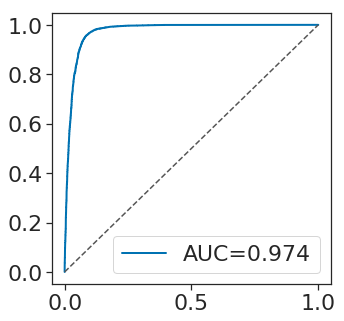

In [5]:
fpr, tpr, thresh = roc_curve(y_test, y_pred)
i = len(thresh) - np.searchsorted(thresh[::-1], 0.9)
print(thresh[i], fpr[i], tpr[i])
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, color=pal[0], lw=2, label='AUC={:.3f}'.format(roc_auc_score(y_test, y_pred)))
ax.plot([0, 1], [0, 1], color='#555555', ls='--')
plt.legend()
plt.show()

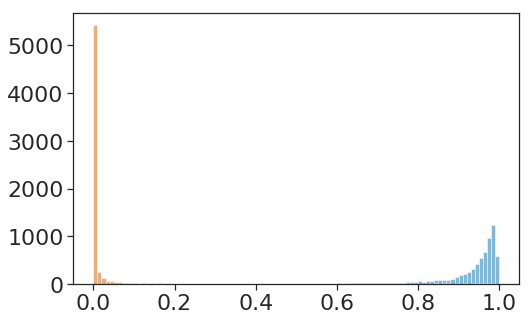

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(y_pred[y_test == 1], bins=np.linspace(0, 1, 101), color=pal[0], alpha=0.5)
ax.hist(y_pred[y_test == 0], bins=np.linspace(0, 1, 101), color=pal[1], alpha=0.5)
plt.show()

In [7]:
# use the existing model to remove false negatives from BLAST

with h5py.File('data/training_data_round1.h5') as f:
    pos_signals = f['pos_signals'][:]
    neg_signals = f['neg_signals'][:]
    neg_signals_internal = f['neg_internal_signals'][:]
    
preds = model.predict(neg_signals.reshape(-1, 3000, 1)).squeeze()
neg_signals_filt = neg_signals[preds < 0.5]

In [10]:
write_to_hdf5(
    'data/training_data_round2.h5',
    pos_signals, neg_signals_filt, neg_signals_internal
)

In [12]:
with h5py.File('data/training_data_round2.h5') as f:
    print(f['pos_signals'].shape)
    print(f['neg_signals'].shape)

(72083, 3000)
(123739, 3000)


In [11]:
train_gen, val_gen, test_data, _ = generate_training_data(
    'data/training_data_round2.h5',
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    val_steps_per_epoch=VAL_STEPS_PER_EPOCH
)
model = build_model(3000)
model, history = train_model(
    model, train_gen, val_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    val_steps_per_epoch=VAL_STEPS_PER_EPOCH
)

Reading in HDF data
Splitting training and test datasets
Building Sequence generators
Epoch 1/100
 - 33s - loss: 0.5769 - val_loss: 0.4159
Epoch 2/100
 - 26s - loss: 0.3923 - val_loss: 0.3292
Epoch 3/100
 - 26s - loss: 0.2839 - val_loss: 0.2378
Epoch 4/100
 - 26s - loss: 0.2272 - val_loss: 0.2264
Epoch 5/100
 - 26s - loss: 0.1843 - val_loss: 0.2926
Epoch 6/100
 - 26s - loss: 0.1446 - val_loss: 0.2128
Epoch 7/100
 - 25s - loss: 0.1355 - val_loss: 0.1220
Epoch 8/100
 - 26s - loss: 0.1289 - val_loss: 0.1180
Epoch 9/100
 - 26s - loss: 0.1106 - val_loss: 0.1059
Epoch 10/100
 - 26s - loss: 0.1182 - val_loss: 0.1946
Epoch 11/100
 - 25s - loss: 0.1023 - val_loss: 0.1340
Epoch 12/100
 - 26s - loss: 0.1017 - val_loss: 0.0999
Epoch 13/100
 - 26s - loss: 0.0948 - val_loss: 0.1006
Epoch 14/100
 - 26s - loss: 0.0946 - val_loss: 0.0981
Epoch 15/100
 - 26s - loss: 0.0876 - val_loss: 0.0974
Epoch 16/100
 - 26s - loss: 0.0897 - val_loss: 0.0802
Epoch 17/100
 - 26s - loss: 0.0862 - val_loss: 0.1037
Epoch

In [12]:
X_test, y_test = test_data
y_pred = model.predict(X_test)

0.8993835 0.004993757802746567 0.9429879317519767


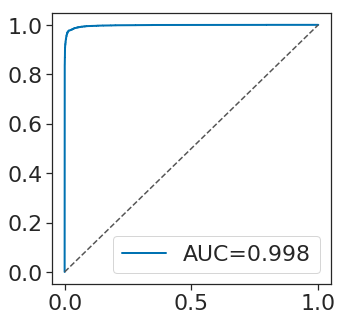

In [13]:
fpr, tpr, thresh = roc_curve(y_test, y_pred)
i = len(thresh) - np.searchsorted(thresh[::-1], 0.9)
print(thresh[i], fpr[i], tpr[i])
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, color=pal[0], lw=2, label='AUC={:.3f}'.format(roc_auc_score(y_test, y_pred)))
ax.plot([0, 1], [0, 1], color='#555555', ls='--')
plt.legend()
plt.show()

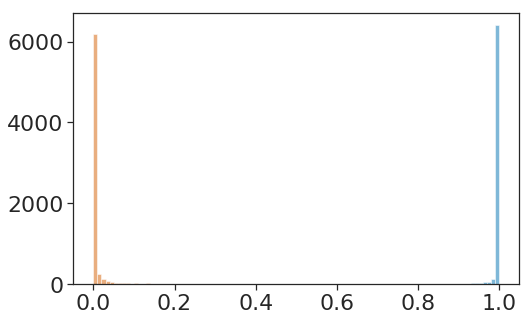

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(y_pred[y_test == 1], bins=np.linspace(0, 1, 101), color=pal[0], alpha=0.5)
ax.hist(y_pred[y_test == 0], bins=np.linspace(0, 1, 101), color=pal[1], alpha=0.5)
plt.show()

In [15]:
model.save('data/model_weights_070319.h5')

Use K Fold cross validation to do proper model evaluation:

In [19]:
def get_data(h5_fn):
    with h5py.File(h5_fn) as h5_file:
        pos = h5_file['pos_signals'][:]
        neg = np.concatenate([
            h5_file['neg_signals'][:],
            h5_file['neg_internal_signals'][:]
        ])
    return pos, neg

pos_data, neg_data = get_data('data/training_data_round2.h5')
pos_kf = KFold(n_splits=5, shuffle=False).split(pos_data)
neg_kf = KFold(n_splits=5, shuffle=False).split(neg_data)
pos_pred = []
neg_pred = []

for (pos_train_idx, pos_test_idx), (neg_train_idx, neg_test_idx) in zip(pos_kf, neg_kf):
    pos_train = pos_data[pos_train_idx]
    pos_test = pos_data[pos_test_idx]
    neg_train = neg_data[neg_train_idx]
    neg_test = neg_data[neg_test_idx]
    pos_train, pos_val = train_test_split(pos_train, test_size=0.1)
    neg_train, neg_val = train_test_split(neg_train, test_size=0.1)
    train_gen = SquiggleSequence(
        pos_train, neg_train,
        batch_size=128, steps_per_epoch=100,
    )
    val_gen = SquiggleSequence(
        pos_val, neg_val,
        batch_size=128, steps_per_epoch=20,
    )
    model = build_model(3000)
    model, history = train_model(
        model, train_gen, val_gen,
        epochs=100,
        steps_per_epoch=100,
        val_steps_per_epoch=20
    )
    pos_pred.append(model.predict(pos_test.reshape(-1, 3000, 1)).squeeze())
    neg_pred.append(model.predict(neg_test.reshape(-1, 3000, 1)).squeeze())

pos_pred = np.concatenate(pos_pred)
neg_pred = np.concatenate(neg_pred)

Epoch 1/100
 - 34s - loss: 0.6771 - val_loss: 0.5476
Epoch 2/100
 - 26s - loss: 0.4113 - val_loss: 0.3822
Epoch 3/100
 - 27s - loss: 0.3050 - val_loss: 0.3674
Epoch 4/100
 - 26s - loss: 0.2376 - val_loss: 0.2558
Epoch 5/100
 - 27s - loss: 0.1894 - val_loss: 0.2954
Epoch 6/100
 - 26s - loss: 0.1637 - val_loss: 0.1519
Epoch 7/100
 - 26s - loss: 0.1442 - val_loss: 0.1723
Epoch 8/100
 - 26s - loss: 0.1421 - val_loss: 0.1069
Epoch 9/100
 - 27s - loss: 0.1399 - val_loss: 0.1168
Epoch 10/100
 - 27s - loss: 0.1310 - val_loss: 0.2195
Epoch 11/100
 - 27s - loss: 0.1163 - val_loss: 0.1435
Epoch 12/100
 - 26s - loss: 0.1121 - val_loss: 0.1124
Epoch 13/100
 - 26s - loss: 0.1100 - val_loss: 0.0796
Epoch 14/100
 - 26s - loss: 0.1042 - val_loss: 0.0674
Epoch 15/100
 - 27s - loss: 0.1025 - val_loss: 0.0763
Epoch 16/100
 - 27s - loss: 0.1033 - val_loss: 0.0758
Epoch 17/100
 - 26s - loss: 0.1080 - val_loss: 0.0926
Epoch 18/100
 - 27s - loss: 0.1038 - val_loss: 0.0775
Epoch 19/100
 - 27s - loss: 0.1004 - 

0.8999793 0.0055848859025262884 0.9163880526615152


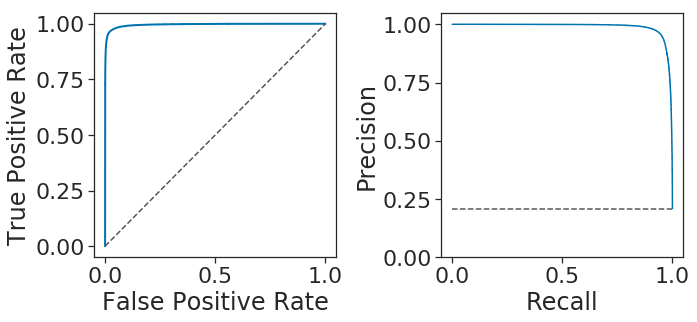

In [45]:
y_pred = np.concatenate([pos_pred, neg_pred])
y_true = np.concatenate([[1] * len(pos_pred), [0] * len(neg_pred)])

fpr, tpr, thresh = roc_curve(y_true, y_pred)
prec, rec, pr_thresh = precision_recall_curve(y_true, y_pred)
i = len(thresh) - np.searchsorted(thresh[::-1], 0.9)
print(thresh[i], fpr[i], tpr[i])
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes[0].plot(fpr, tpr, color=pal[0], lw=2)
axes[0].plot([0, 1], [0, 1], color='#555555', ls='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[1].plot(rec, prec)
axes[1].plot([0, 1], [prec[1], prec[1]], color='#555555', ls='--')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig('figures/roc_pr_curve.svg')
plt.show()